<a href="https://colab.research.google.com/github/Kushagratandon12/Diabetic_retinopathy/blob/main/Diabetic_Retinopathy2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! pip install split-folders
 
# #Download Dataset 
# !kaggle datasets download -d kushagratandon12/diabetic-retinopathy-processed-data
# !unzip /content/diabetic-retinopathy-processed-data.zip
# !rm -rf '/content/diabetic-retinopathy-processed-data.zip'

In [2]:
import numpy as np
import pandas as pd
import glob
import os 
from tqdm import tqdm
from os import path
import gc
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.applications.resnet_v2 import  ResNet50V2
import splitfolders

In [3]:
drive.mount('/content/drive')
gc.collect()

Mounted at /content/drive


72

In [4]:
dataset = glob.glob('/content/processed_data/*/*.jpeg')
print('Total Number Of Images {}'.format(len(dataset)))

Total Number Of Images 35126


In [5]:
classes=['No_Dr','Mild','Moderate','severe','Proliferative DR']
class_dict = {}
for i,label in enumerate(classes):
  class_dict[i]=label
print(class_dict)

{0: 'No_Dr', 1: 'Mild', 2: 'Moderate', 3: 'severe', 4: 'Proliferative DR'}


Dataset -  

*   No Dr
*   Mild
*   Moderate
*   Severe
*   Proliferative DR







Reducing The Images of No-DR i.e 0

In [6]:
# ammount to be removed = 10800
label_1 = glob.glob('/content/processed_data/0/*.jpeg')
label_1 = list(label_1[12800::])
print(len(label_1))
for i in range(len(label_1)):
  os.remove(label_1[i])

13010


## Make Training Dataframe of images

In [7]:
img_files = [os.path.basename(name) for name in dataset]
data_label = [int(name.split('/')[-2]) for name in dataset]

df = pd.DataFrame({'filename':img_files,'label':data_label})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0    25810
2     5292
1     2443
3      873
4      708
Name: label, dtype: int64

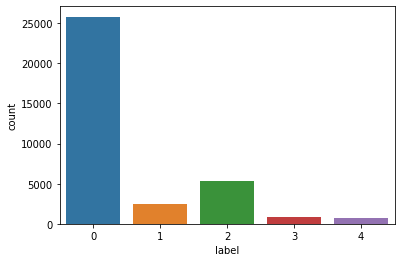

In [8]:
sns.countplot(df['label'])
df['label'].value_counts()

In [35]:
df_minor = df.loc[(df['label'] !=0)&(df['label']!=1) &(df['label']!=2)]
df_minor.head()

minor_imgs =[]
for iter,row in df_minor.iterrows():
    fname = os.path.join(os.path.join('/content/processed_data',str(row.label)),
                         row.filename)
    minor_imgs.append(fname)
print(len(minor_imgs))
gc.collect()

1581


21518

In [36]:
diabetic_imgs= minor_imgs
diabetic_imgs = np.asarray(diabetic_imgs)
np.random.shuffle(diabetic_imgs)
print(diabetic_imgs.shape)

(1581,)


## Image Aug using keras 

In [37]:
from google.colab.patches import cv2_imshow
plt.figure(figsize=(10, 10))


def decode_img(filename,shape=(512,512)):
    img = image.load_img(filename,target_size=(shape))
    img  = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    print(img.shape)
    return img

data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomRotation((0.1,0.3),fill_mode='nearest'),
      layers.experimental.preprocessing.RandomZoom(0.2),
      layers.experimental.preprocessing.RandomContrast(0.2)
          ])

# for filename in diabetic_imgs:
#     print(filename)
#     img_decoded = decode_img(filename)
#     for i in range(3):
#         augmented_image = data_augmentation(img_decoded)
#         augmented_image = np.squeeze(augmented_image, axis=0)
#         ax = plt.subplot(3, 3, i + 1)
#         cv2_imshow(augmented_image)
#         plt.axis("off")
#     break 


<Figure size 720x720 with 0 Axes>

## Image Aug using IMAGAUG 

In [38]:
from imgaug import augmenters as iaa
import imageio
from google.colab.patches import cv2_imshow
plt.figure(figsize=(10, 10))

seq = iaa.Sequential([
    		iaa.Crop(px=(0, 16)),
    		iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-25,25)),
            iaa.LinearContrast(alpha=1.2)
    		])

def read_img(filename,shape=(512,512)):
    img = image.load_img(filename,target_size=(shape))
    img  = image.img_to_array(img)
    return img

def load_batch(img_list,batch=32,count=0):
    imgs = [] 
    fnames  = []
    i = count*batch
    for filename in img_list[i:batch*(count+1)]:
        img = read_img(filename)
        imgs.append(img)
        fnames.append(filename)
    return imgs,fnames

nb_batches  =  len(diabetic_imgs)//32
print(nb_batches)

for idx in tqdm(range(nb_batches),position=0):
    images,fnames = load_batch(diabetic_imgs,count=idx)
    images_aug = seq(images=images)
    for im, im_aug in enumerate(images_aug):
        name = fnames[im][:-4]+'_aug_'+str(im)+'.jpeg'
        imageio.imwrite(name, im_aug)

gc.collect()
    

100%|██████████| 49/49 [00:54<00:00,  1.12s/it]


139

<Figure size 720x720 with 0 Axes>

Total Number Of Images 32941


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


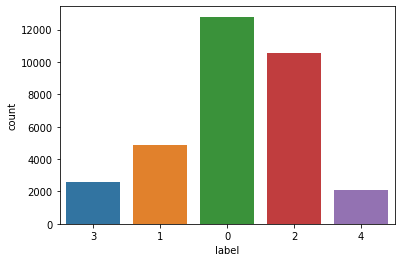

In [39]:
aug_dataset = glob.glob('/content/processed_data/*/*.jpeg')
print('Total Number Of Images {}'.format(len(aug_dataset)))

img_files = [os.path.basename(name) for name in aug_dataset]
train_label = [name.split('/')[-2] for name in aug_dataset]

aug_df = pd.DataFrame({'filename':img_files,'label':train_label})
sns.countplot(aug_df['label'])



In [40]:
aug_df['label'].value_counts()

0    12800
2    10581
1     4885
3     2575
4     2100
Name: label, dtype: int64

#Model Creation


In [17]:
input_data = '/content/processed_data'
output_data = '/content/output'
! mkdir /content/output
if len(os.listdir(output_data))==0:
  splitfolders.ratio(input_data, output=output_data,seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 31428 files [00:23, 1351.41 files/s]


In [41]:
#Hyper-Parameter Declarations 
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT)
EPOCH = 30
test_data = '/content/output/test'
training_data = '/content/output/train'
validation_data = '/content/output/val'

In [42]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255)

In [43]:
training_datagen = image_data_generator.flow_from_directory(
    training_data,
    target_size=IMG_SHAPE,
    shuffle=True,
)

validation_datagen = image_data_generator.flow_from_directory(
    validation_data,
    target_size=IMG_SHAPE,
    shuffle = True
)

test_datagen = image_data_generator.flow_from_directory(
    test_data,
    target_size=IMG_SHAPE,
    shuffle=True)

Found 25140 images belonging to 5 classes.
Found 3141 images belonging to 5 classes.
Found 3147 images belonging to 5 classes.


In [44]:
def define_model(n_layers=50,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=(512,512,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=True
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)

    if BASE_MODEL =='Custom':
      model = tf.keras.models.Sequential([
              #additing the 1st convolution layers
              tf.keras.layers.Conv2D(32,(3,3) ,activation='relu',input_shape=(512,512,3),padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              #addition the 2nd convolution layers
              tf.keras.layers.Conv2D(32,(3,3) , activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              #addition the 3rd convolution layers
              tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
            
              tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding="same"),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.BatchNormalization(),
              
              # tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding="same"),
              # # tf.keras.layers.MaxPool2D(),
              # # tf.keras.layers.BatchNormalization(),
              
              # tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding="same"),
              # tf.keras.layers.MaxPool2D(),
              # tf.keras.layers.BatchNormalization(),
              # tf.keras.layers.Dropout(0.5),
              
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(1024,activation='relu'),
              tf.keras.layers.Dropout(0.5),
              # tf.keras.layers.Dense(1024,activation='relu'),
              tf.keras.layers.Dense(5, activation='softmax')])
    return model



In [ ]:
model.summary()

In [46]:
model = define_model(BASE_MODEL='Custom')
model.compile(optimizer=RMSprop(lr=0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [47]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Custom_Weights"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,monitor='val_loss', verbose=1,
                            save_best_only=True,mode='min')
# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [ ]:
history = model.fit(
    training_datagen,
    # batch_size=BATCH_SIZE,
    epochs=25,
    # steps_per_epoch=100,
    validation_data=validation_datagen,
    callbacks=[cp_callback,learning_rate_reduction])

Epoch 1/25
786/786 [==============================] - 214s 267ms/step - loss: 1.6227 - accuracy: 0.4798 - val_loss: 1.1558 - val_accuracy: 0.5638

Epoch 00001: val_loss improved from inf to 1.15584, saving model to /content/drive/MyDrive/Colab Notebooks/Custom_Weights
Epoch 2/25
786/786 [==============================] - 209s 266ms/step - loss: 1.1273 - accuracy: 0.5577 - val_loss: 1.0899 - val_accuracy: 0.5689

Epoch 00002: val_loss improved from 1.15584 to 1.08990, saving model to /content/drive/MyDrive/Colab Notebooks/Custom_Weights
Epoch 3/25
786/786 [==============================] - 208s 265ms/step - loss: 1.0609 - accuracy: 0.5828 - val_loss: 1.0481 - val_accuracy: 0.5915

Epoch 00003: val_loss improved from 1.08990 to 1.04808, saving model to /content/drive/MyDrive/Colab Notebooks/Custom_Weights
Epoch 4/25
786/786 [==============================] - 209s 266ms/step - loss: 1.0284 - accuracy: 0.5984 - val_loss: 1.1722 - val_accuracy: 0.5705

Epoch 00004: val_loss did not improve 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()


NameError: ignored

In [ ]:
gc.collect()

2975

In [ ]:
import tensorflow as tf
tf.saved_model.save(model,'/content/drive/MyDrive/Colab Notebooks/Diabetic_Weight')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic_Weight/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic_Weight/assets


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from os.path import join
diab_model = load_model('/content/drive/MyDrive/Colab Notebooks/Diabetic_Weight')
shape = (512,512)
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(filename,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray 
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img



In [ ]:
CLASS_NAMES = training_datagen.class_indices
Labels = list(CLASS_NAMES.keys())
print(Labels)
print(CLASS_NAMES)

['0', '1', '2', '3', '4']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


/content/output/test/4/13669_left._aug_29.jpeg


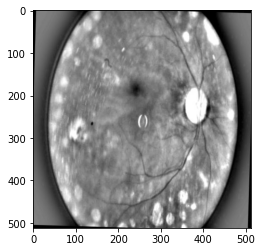

In [ ]:
import glob
import random
test_img = glob.glob('/content/output/test/*/*.jpeg')
img_select = random.randint(1,len(test_img))

print(test_img[img_select])
img = plt.imread(test_img[img_select])
plt.imshow(img,cmap = 'gray')

In [ ]:
test_data =glob.glob('/content/output/test/*/*.jpeg')
print("Test data ",len(test_data))
img_files = [os.path.basename(name) for name in test_data]
test_label = [name.split('/')[-2] for name in test_data]
test_df = pd.DataFrame({'filename':img_files,'label':test_label,})
test_df.to_csv('test_data.csv')
test_df

Test data  3680


,filename,label
0,2553_right._aug_18.jpeg,2
1,34066_left.jpeg,2
2,24092_right.jpeg,2
3,31305_right.jpeg,2
4,7237_right.jpeg,2
...,...,...
3675,26595_right.jpeg,1
3676,34350_right._aug_18.jpeg,1
3677,37792_left._aug_17.jpeg,1
3678,38083_right._aug_5.jpeg,1


In [ ]:
predictions = []
for iter,row in test_df.iterrows():
  filename = join('/content/output/test',join(row.label,row.filename))
  img = decode_img(filename,shape)
  pred = diab_model.predict(img)
  y_classes = np.argmax(((pred > 0.5)+0).ravel())
  predictions.append(pred)

In [ ]:
test_df['pred_label']=predictions
print(predictions[0])
test_df.head()

[[5.5317637e-06 2.2815375e-02 9.2501062e-01 4.5510259e-02 6.6582439e-03]]


,filename,label,pred_label
0,2553_right._aug_18.jpeg,2,"[[5.5317637e-06, 0.022815375, 0.9250106, 0.045..."
1,34066_left.jpeg,2,"[[0.0020567728, 0.00074405683, 0.752894, 0.229..."
2,24092_right.jpeg,2,"[[0.5877661, 0.09938885, 0.31264547, 0.0001976..."
3,31305_right.jpeg,2,"[[0.024234539, 0.006118406, 0.75766206, 0.1700..."
4,7237_right.jpeg,2,"[[0.15913822, 0.011567347, 0.8145898, 0.009391..."


In [ ]:
y_test = test_df['label'].astype(int)
y_pred = test_df['pred_label']

In [ ]:
y_pred = test_df.apply(lambda row: np.argmax(list(row['pred_label'])) , axis=1)
print(y_test)

0       2
1       2
2       2
3       2
4       2
       ..
3675    1
3676    1
3677    1
3678    1
3679    1
Name: label, Length: 3680, dtype: int64


In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.69      0.94      0.80      1280
           1       0.62      0.55      0.58       724
           2       0.53      0.42      0.47      1058
           3       0.66      0.28      0.39       340
           4       0.63      0.65      0.64       278

    accuracy                           0.63      3680
   macro avg       0.63      0.57      0.58      3680
weighted avg       0.62      0.63      0.61      3680



<Figure size 432x288 with 0 Axes>

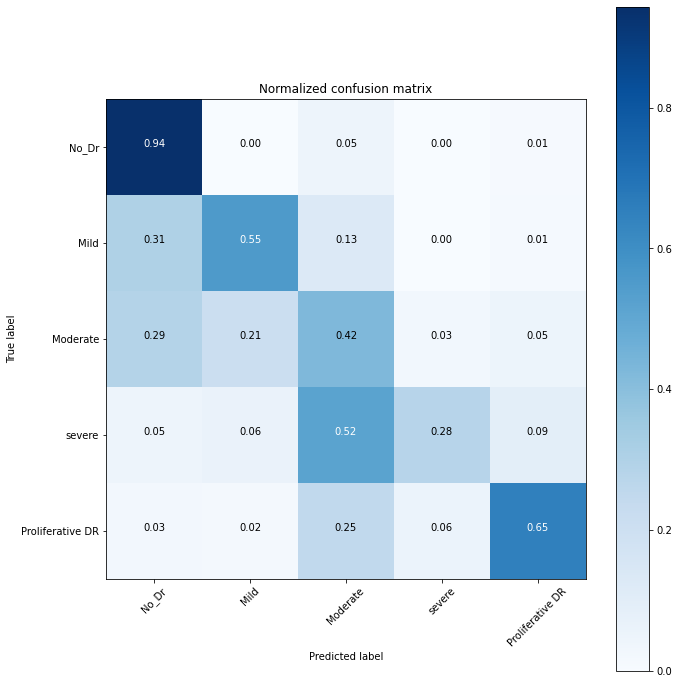

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.set_printoptions(precision=2)


# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, title='Normalized confusion matrix')
plt.show()